In [5]:
from music21 import converter, instrument, note, chord
#from keras import Sequential
import torch
from torch import nn, tensor
import glob
from keras import utils
import numpy as np

In [27]:
def get_notes():
    """ Get all the notes and chords from the midi files in the ./full_set_beethoven_mozart directory. Call BEFORE train """
    notes = []
    durations = []

    for file in glob.glob(r'C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\*.mid'):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi) #Change to only grab the piano???
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch) + " " +  str(element.quarterLength))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder) + " " + str(element.quarterLength))
            elif isinstance(element, note.Rest):
                notes.append(str(element.name)  + " " + str(element.quarterLength))

    return notes

notes = get_notes()

Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\appass_1_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\appass_2_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\appass_3_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\beethoven_hammerklavier_1_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\beethoven_hammerklavier_2_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\beethoven_hammerklavier_3_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\beethoven_hammerklavier_4_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\beethoven_les_adieux_1_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\beethoven_les_adieux_2_format0.mid
Parsing C:\Users\HyoJP\Desktop\BWSI\week4\full_set_beethoven_mozart\beethoven_les_adieux_3_format0.mid


In [28]:
import pickle

with open('beeth_and_moz_ours.pkl', mode='wb') as file:
    pickle.dump(notes, file)

In [2]:
import pickle
notes=[]
with open('beeth_and_moz_ours.pkl', mode='rb') as file:
    notes = pickle.load(file)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_vocab = len(set(notes))
print(device)
print(len(notes), notes[:100])

cuda
111353 ['rest 1.75', 'rest 10.5', 'rest 24.5', 'rest 132.75', 'B-1 0.25', '10.2.5 0.75', '10.2.5 0.25', '10.2.5 1/3', 'rest 1/6', '10.2.3.5 0.25', '10.2.5 0.25', '10.2.5 0.25', 'rest 0.25', '10.2.5 0.25', 'rest 1.0', 'B-1 0.25', '10.2.5 0.75', '10.2.5 0.25', '10.2.5 1/3', 'rest 1/6', '2.5.7.10 0.25', '10.2.5 0.25', '10.2.5 0.25', 'rest 0.25', '10.2.5 0.25', 'rest 0.75', 'B-4 0.25', 'C5 0.25', 'D5 1.0', '4.7 0.5', '5.9.0 0.5', 'rest 0.5', '8.11 0.5', 'C5 0.25', 'D5 0.25', 'E-5 1.0', '7.0 0.5', '6.9 0.5', '7.10.2 0.5', 'rest 0.5', '3.7 0.5', 'D5 0.25', 'E-5 0.25', '2.5 0.5', 'F5 0.75', '10.1 0.5', 'G5 0.25', '7.0 0.5', 'F5 0.25', 'E-5 0.5', '5.9 0.5', 'F5 0.25', '5.10 0.5', 'E-5 0.25', 'D5 0.25', '0.3.7 0.5', 'F5 0.25', 'E-5 0.25', '5.9.0 0.5', 'rest 1.5', 'B-5 0.25', 'C6 0.25', 'D6 1.0', '4.7 0.5', '5.9.0 0.5', 'rest 0.5', 'C6 0.25', '8.11 0.5', 'D6 0.25', '7.0 0.5', 'E-6 1.0', '6.9 0.5', '7.10.2 0.5', 'rest 0.5', '3.7 0.5', 'D6 0.25', 'E-6 0.25', 'F6 0.75', '2.5 0.5', '10.1 0.5', 

In [9]:
# preprocessing
sequence_length = 100
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    print(len(pitchnames))
    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = utils.to_categorical(network_output)

    return (network_input, network_output, pitchnames)


network_input, network_output, pitchnames = prepare_sequences(notes, n_vocab)

'''import numpy as np
from keras.utils import np_utils

sequence_length = 100# get all pitch names
pitchnames = sorted(set(item for item in notes))# create a dictionary to map pitches to integers

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []# create input sequences and the corresponding outputs

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)'''

2581


'import numpy as np\nfrom keras.utils import np_utils\n\nsequence_length = 100# get all pitch names\npitchnames = sorted(set(item for item in notes))# create a dictionary to map pitches to integers\n\nnote_to_int = dict((note, number) for number, note in enumerate(pitchnames))\n\nnetwork_input = []\nnetwork_output = []# create input sequences and the corresponding outputs\n\nfor i in range(0, len(notes) - sequence_length, 1):\n    sequence_in = notes[i:i + sequence_length]\n    sequence_out = notes[i + sequence_length]\n    network_input.append([note_to_int[char] for char in sequence_in])\n    network_output.append(note_to_int[sequence_out])\n\nn_patterns = len(network_input)# reshape the input into a format compatible with LSTM layers\nnetwork_input = np.reshape(network_input, (n_patterns, sequence_length, 1))\n# normalize input\nnetwork_input = network_input / float(n_vocab)\nnetwork_output = np_utils.to_categorical(network_output)'

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.LSTM(input_size=1, hidden_size=512, proj_size=256, batch_first=True, bidirectional=True)
        self.layer2 = nn.LSTM(input_size=512, hidden_size=512, proj_size=256, batch_first=True, num_layers=2)
        self.layer3 = nn.Linear(256, n_vocab)

        self.norm1 = torch.nn.BatchNorm1d(sequence_length)
        
        for layer in (self.layer1, self.layer2):
            for name, param in layer.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0.0)
                elif 'weight' in name:
                    nn.init.xavier_normal_(param)
        
        
        nn.init.xavier_normal_(self.layer3.weight, np.sqrt(2))
        nn.init.constant_(self.layer3.bias, 0)
            
    def forward(self, x):
        x2, (h,c) = self.layer1(x)
        x3, (h,c) = self.layer2(nn.functional.dropout(x2, 0.3), (h,c))
        x4 = self.layer3(self.norm1(nn.functional.dropout(x3, 0.3)))
        return x4

In [26]:
model = Model().to(device)

In [27]:
optim = torch.optim.Adam(model.parameters(), lr=1e-5)

<IPython.core.display.Javascript object>


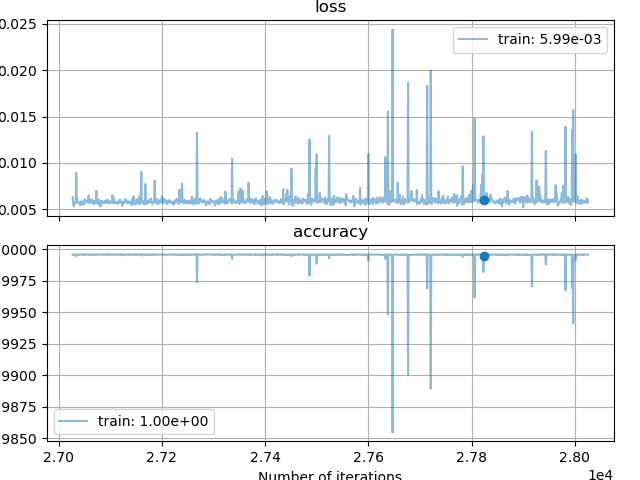

In [28]:
from noggin import create_plot
import matplotlib
%matplotlib notebook
plotter, fig, ax = create_plot(metrics=['loss', 'accuracy'], last_n_batches=1000)

In [29]:
def accuracy(predictions, truth):
    return np.mean((torch.argmax(predictions, dim=1) == truth).cpu().numpy())

In [30]:
batch_size = 64
epochs = 40

for e in range(epochs):
    index = np.arange(len(network_input))
    np.random.shuffle(index)
    
    loss = None
    for batch in range(0, len(network_input), batch_size):
        
        batch_indices = index[batch:batch+batch_size]
        x_train = network_input[batch_indices]
        y_train = network_output[batch_indices]
        
        train_data = torch.tensor(x_train, dtype=torch.float32, device='cuda').to(device)
        test_data = torch.tensor(y_train, dtype=torch.long, device='cuda').to(device)
        
        y_pred = model(train_data)
        loss = nn.functional.cross_entropy(y_pred, test_data)
        acc = accuracy(y_pred, test_data)
        loss.backward()
        optim.step()
        
        plotter.set_train_batch({"loss" : loss.item(), "accuracy" : acc}, batch_size=batch_size)
        
    plotter.set_train_epoch()
    
    
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
            }, '././combined.tar')
    print("EPOCH: ", e)
plotter.plot()

EPOCH:  0
EPOCH:  1
EPOCH:  2
EPOCH:  3
EPOCH:  4
EPOCH:  5
EPOCH:  6
EPOCH:  7
EPOCH:  8
EPOCH:  9
EPOCH:  10
EPOCH:  11
EPOCH:  12
EPOCH:  13
EPOCH:  14
EPOCH:  15


KeyboardInterrupt: 

In [ ]:
'''checkpoint = torch.load('././checkpoint.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()'''

In [78]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [79]:
def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    print(len(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model(torch.tensor(prediction_input, dtype=torch.float32, device='cuda'))
        #print(prediction.shape, n_vocab)
        index = np.argmax(prediction.cpu().detach())
        result = int_to_note[index.item()]
        #print(result)
        '''if 'rest' in result:
            if convert_to_float(s[5:]) > 4:
                result = 'rest 4.0'''
                
        prediction_output.append(result)

        pattern = np.append(pattern, index)
        pattern = pattern[1:len(pattern)]

    return prediction_output


prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
for result in range(len(prediction_output)):
    if 'rest' in prediction_output[result]:
            if convert_to_float(prediction_output[result][5:]) > 4:
                prediction_output[result] = 'rest 4.0'

'''start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
# generate 500 notes

for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    
    prediction = model(torch.tensor(prediction_input, dtype=torch.float32, device='cuda'))
    index = np.argmax(prediction.cpu().detach())
    result = int_to_note[index.item()]
    
    prediction_output.append(result)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]
    
print(pattern.shape)'''

2581


"start = np.random.randint(0, len(network_input)-1)\nint_to_note = dict((number, note) for number, note in enumerate(pitchnames))\npattern = network_input[start]\nprediction_output = []\n# generate 500 notes\n\nfor note_index in range(500):\n    prediction_input = np.reshape(pattern, (1, len(pattern), 1))\n    prediction_input = prediction_input / float(n_vocab)\n    \n    prediction = model(torch.tensor(prediction_input, dtype=torch.float32, device='cuda'))\n    index = np.argmax(prediction.cpu().detach())\n    result = int_to_note[index.item()]\n    \n    prediction_output.append(result)\n    pattern = np.append(pattern, index)\n    pattern = pattern[1:len(pattern)]\n    \nprint(pattern.shape)"

In [86]:
from music21 import stream

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        pattern = pattern.split()
        temp = pattern[0]
        duration = pattern[1]
        pattern = temp
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.duration.quarterLength = offset/4
            new_chord.offset = offset/4
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset/4
            new_rest.storedInstrument = instrument.Piano() #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.duration.quarterLength = offset/4
            new_note.offset = offset/4
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')

create_midi(prediction_output)

In [87]:
import pygame
def play_music(midi_filename):
    clock = pygame.time.Clock()
    pygame.mixer.music.load(midi_filename)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        clock.tick(30)
    
midi_filename = 'test_output.mid'

In [88]:
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

try:
  # use the midi file you just saved
    play_music(midi_filename)
except KeyboardInterrupt:
  # if user hits Ctrl/C then exit
  # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()

In [65]:
print(prediction_output[:50])

['5.11 2.0', '2.5.8 1.0', 'C2 4.0', '11.3 1.75', 'B-3 1.25', 'C#4 9.0', 'rest 4.0', 'rest 4.0', 'B-3 1.25', '2.3.5 0.25', 'rest 4.0', 'C#2 1.5', '5.8.10 1.0', 'C#2 1.5', 'G#4 2.5', '4.5 0.25', 'B4 8/3', 'G#4 2.5', '9.11.3 3.0', 'G#4 1.5', 'B-3 1.25', '9.2 0.5', 'B-3 1.25', 'B-3 1.25', 'rest 4.0', '11.2 0.25', 'rest 4.0', '6.9.0 4.0', 'F6 1.25', 'C#2 1.5', '5.8.10 1.0', 'C2 0.5', 'B4 8/3', '11 4.0', 'G#4 2.5', 'B4 8/3', '2.5.8 1.0', 'B4 8/3', 'rest 4.0', '5.7 2/3', '4.5 0.25', 'rest 4.0', '2.6.7 0.5', '11.1.2 1.0', 'G6 1.0', 'B-3 1.25', 'rest 4.0', 'C#2 1.5', '0.3.6.9 2.0', 'G#4 2.5']
